<a href="https://colab.research.google.com/github/Kavya2099/mlbookcamp/blob/model-predictions/Decision_Trees_and_Ensemble_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Trees and Ensemble Learning

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

Credit risk scoring project

In [ ]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

df = pd.read_csv(data)
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


# Data cleaning and preparation

As we can see, we have all the features to be numerical variables. Status will be the target feature. 

We can see the status to be 1 and 2, but not sure what is mean by that and similarly marital status,etc....

Let us investigate about that more

In [ ]:
df.columns = df.columns.str.lower()
df.columns

Index(['status', 'seniority', 'home', 'time', 'age', 'marital', 'records',
       'job', 'expenses', 'income', 'assets', 'debt', 'amount', 'price'],
      dtype='object')

In [ ]:
df.status.value_counts()

1    3200
2    1254
0       1
Name: status, dtype: int64

We can see 1 and 2 has more values, we'll indicate that to be 1 - ok, 2- default, 0 -unknown

similarly for all other columns based on the analysis of the data

In [ ]:
status_values= { 1: 'ok', 2: 'default', 0: 'unknown'}

df.status = df.status.map(status_values)
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,1,60,30,2,1,3,73,129,0,0,800,846
1,ok,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,default,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,ok,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,ok,0,1,36,26,1,1,1,46,107,0,0,310,910


In [ ]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unknown'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unknown'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unknown'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unknown'
}

df.job = df.job.map(job_values)

In [ ]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [ ]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


We can see that the assests, income and debt features has max value to be 99999999.0. 

We'll change this w.r.t the second largest value...i.e removing this value

In [ ]:
c = ['income','assets','debt']

for c in df[c]:
  df[c]= df[c].replace(to_replace=99999999.0 , value= np.nan)

In [ ]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [ ]:
# dropping unknown status 0


df = df[df.status != 'unknown']
df.head()
df.status.value_counts()

ok         3200
default    1254
Name: status, dtype: int64

In [ ]:
df.dtypes

status        object
seniority      int64
home          object
time           int64
age            int64
marital       object
records       object
job           object
expenses       int64
income       float64
assets       float64
debt         float64
amount         int64
price          int64
dtype: object

In [ ]:
#test train split

from sklearn.model_selection import train_test_split
df= df.fillna(0)
df1= df
#df = df.reset_index(drop=True)
X= df.drop(['status'],axis=1)

y= df.status
#changing the string value to int type for getting auc score
y = (df.status == 'default').astype('int').values
X = pd.get_dummies(X)

X_full_train,X_val, y_full_train, y_val = train_test_split(X,y,test_size=0.2,random_state=11)
X_train, X_test, y_train, y_test = train_test_split(X_full_train, y_full_train, test_size=0.25,random_state=11)

In [ ]:
X

,seniority,time,age,expenses,income,assets,debt,amount,price,home_ignore,...,marital_single,marital_unknown,marital_widow,records_no,records_yes,job_fixed,job_freelance,job_others,job_partime,job_unknown
0,9,60,30,73,129.0,0.0,0.0,800,846,0,...,0,0,0,1,0,0,1,0,0,0
1,17,60,58,48,131.0,0.0,0.0,1000,1658,0,...,0,0,1,1,0,1,0,0,0,0
2,10,36,46,90,200.0,3000.0,0.0,2000,2985,0,...,0,0,0,0,1,0,1,0,0,0
3,0,60,24,63,182.0,2500.0,0.0,900,1325,0,...,1,0,0,1,0,1,0,0,0,0
4,0,36,26,46,107.0,0.0,0.0,310,910,0,...,1,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4450,1,60,39,69,92.0,0.0,0.0,900,1020,0,...,0,0,0,1,0,1,0,0,0,0
4451,22,60,46,60,75.0,3000.0,600.0,950,1263,0,...,0,0,0,1,0,1,0,0,0,0
4452,0,24,37,60,90.0,3500.0,0.0,500,963,0,...,0,0,0,1,0,0,0,0,1,0
4453,0,48,23,49,140.0,0.0,0.0,550,550,0,...,1,0,0,1,0,0,1,0,0,0


We have prepared the data, so now we'll try with differenet models and measure accuracy and auc score

# Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [ ]:
from sklearn.metrics import accuracy_score



dmodel = DecisionTreeClassifier(random_state=0)
dmodel.fit(X_train, y_train)

pred1 = dmodel.predict(X_val)

print('ACCURACY: ',accuracy_score(y_val,pred1)*100)
print('AUC score: ',roc_auc_score(y_val,pred1))

ACCURACY:  68.91133557800224
AUC score:  0.6236223791603538


In [ ]:
""" df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values
del df_train['status']
del df_val['status']
del df_test['status'] """

"""


train_dicts = X_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
DecisionTreeClassifier()
val_dicts = X_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_pred = dt.predict_proba(X_val)[:, 1]
print(roc_auc_score(y_val, y_pred))
print('ACCURACY: ',accuracy_score(y_val, y_pred)*100) """

"\n\n\ntrain_dicts = X_train.fillna(0).to_dict(orient='records')\ndv = DictVectorizer(sparse=False)\nX_train = dv.fit_transform(train_dicts)\ndt = DecisionTreeClassifier()\ndt.fit(X_train, y_train)\nDecisionTreeClassifier()\nval_dicts = X_val.fillna(0).to_dict(orient='records')\nX_val = dv.transform(val_dicts)\ny_pred = dt.predict_proba(X_val)[:, 1]\nprint(roc_auc_score(y_val, y_pred))\nprint('ACCURACY: ',accuracy_score(y_val, y_pred)*100) "

# Decision trees parameter tuning




1. selecting max_depth
2. selecting min_samples_leaf


In [ ]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]


for d in depths:
  dmodel = DecisionTreeClassifier(random_state=0,max_depth=d)
  dmodel.fit(X_train, y_train)

  pred1 = dmodel.predict(X_val)
  acc= accuracy_score(y_val,pred1)*100
  auc = roc_auc_score(y_val,pred1)
  print('%4s -> auc %.3f accuracy  %.2f' % (d, auc, acc))
 

   1 -> auc 0.597 accuracy  71.83
   2 -> auc 0.636 accuracy  73.96
   3 -> auc 0.618 accuracy  73.18
   4 -> auc 0.627 accuracy  74.52
   5 -> auc 0.670 accuracy  75.98
   6 -> auc 0.670 accuracy  74.97
  10 -> auc 0.640 accuracy  73.40
  15 -> auc 0.631 accuracy  70.26
  20 -> auc 0.624 accuracy  68.91
None -> auc 0.624 accuracy  68.91


As we can see w.r.t auc --> depth 4 and 5 are  good and w.r.t acc--> depth 5 and 6 are good

So we'll try max sample leaf with these 3 depth

In [ ]:
depth = [4,5,6]
leaf=[1, 5, 10, 15, 20, 500, 100, 200]
scores=[]
for d in depth:
  for l in leaf:
    dmodel = DecisionTreeClassifier(random_state=0,max_depth=d,min_samples_leaf=l)
    dmodel.fit(X_train, y_train)
    
    pred1 = dmodel.predict(X_val)
    acc= accuracy_score(y_val,pred1)*100
    auc = roc_auc_score(y_val,pred1)
    print('%4s %s -> auc %.3f accuracy  %.2f' % (d, l, auc, acc))

    scores.append((d,l, acc, auc))
    

   4 1 -> auc 0.627 accuracy  74.52
   4 5 -> auc 0.627 accuracy  74.52
   4 10 -> auc 0.627 accuracy  74.52
   4 15 -> auc 0.634 accuracy  74.97
   4 20 -> auc 0.630 accuracy  74.97
   4 500 -> auc 0.634 accuracy  71.38
   4 100 -> auc 0.611 accuracy  73.74
   4 200 -> auc 0.635 accuracy  73.96
   5 1 -> auc 0.670 accuracy  75.98
   5 5 -> auc 0.671 accuracy  76.09
   5 10 -> auc 0.667 accuracy  75.20
   5 15 -> auc 0.676 accuracy  76.21
   5 20 -> auc 0.666 accuracy  76.32
   5 500 -> auc 0.634 accuracy  71.38
   5 100 -> auc 0.654 accuracy  75.42
   5 200 -> auc 0.635 accuracy  73.96
   6 1 -> auc 0.670 accuracy  74.97
   6 5 -> auc 0.673 accuracy  75.53
   6 10 -> auc 0.673 accuracy  74.52
   6 15 -> auc 0.682 accuracy  74.97
   6 20 -> auc 0.673 accuracy  75.31
   6 500 -> auc 0.634 accuracy  71.38
   6 100 -> auc 0.654 accuracy  75.42
   6 200 -> auc 0.635 accuracy  73.96


We are getting accuracy of 76.21 and auc of 0.668 when we use depth=5 and samples=15.
We'll us the that same for our final decision tree classifier



In [ ]:
columns = ['max_depth', 'min_samples_leaf', 'acc','auc']
df_scores = pd.DataFrame(scores, columns=columns)


pivot1 = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['acc'])
pivot1.round(3)


acc                
max_depth              4       5       6
min_samples_leaf                        
1                 74.523  75.982  74.972
5                 74.523  76.094  75.533
10                74.523  75.196  74.523
15                74.972  76.207  74.972
20                74.972  76.319  75.309
100               73.737  75.421  75.421
200               73.962  73.962  73.962
500               71.380  71.380  71.380

In [ ]:
pivot2 = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
pivot2.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.627  0.670  0.670
5                 0.627  0.671  0.673
10                0.627  0.667  0.673
15                0.634  0.676  0.682
20                0.630  0.666  0.673
100               0.611  0.654  0.654
200               0.635  0.635  0.635
500               0.634  0.634  0.634

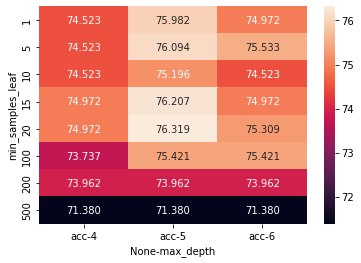

In [ ]:
# plot the same in heatmap
sns.heatmap(pivot1, annot=True, fmt=".3f")


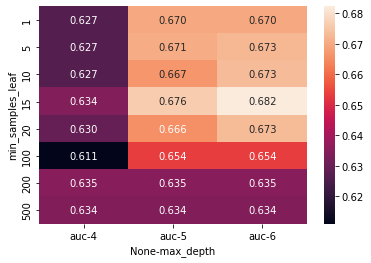

In [ ]:
sns.heatmap(pivot2, annot=True, fmt=".3f")

In [ ]:
dmodel = DecisionTreeClassifier(random_state=0,max_depth=5,min_samples_leaf=15)
dmodel.fit(X_train, y_train)

pred1 = dmodel.predict(X_val)
acc= accuracy_score(y_val,pred1)*100
auc = roc_auc_score(y_val,pred1)
print('%4s -> auc %.3f accuracy  %.2f' % (5, auc, acc))



   5 -> auc 0.676 accuracy  76.21


We have taken both auc and acc under consideration and fixed our final parameters value.


# Ensembles and random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier


rmodel = RandomForestClassifier(random_state=1)
rmodel.fit(X_train, y_train)

pred2 = rmodel.predict(X_val)

print('ACCURACY: ',accuracy_score(y_val,pred2)*100)
print('AUC score: ',roc_auc_score(y_val,pred2))

ACCURACY:  78.00224466891133
AUC score:  0.6934014710913445


# Random forest parameter tuning


n_estimators, max_depth=max_depth, min_samples_leaf

In [ ]:
depth=[5,10,15,20]
score=[]
score1=[]
for d in depth:
   for n in range(10,201,10):


    rmodel = RandomForestClassifier(n_estimators=n,random_state=1,max_depth=d)
    rmodel.fit(X_train, y_train)

    pred = rmodel.predict(X_val)
    acc= accuracy_score(y_val,pred)*100
    auc = roc_auc_score(y_val,pred)

    #print('%4s %s  %.2f %.3f'%(n,d,acc,auc))
    score.append((d,n,acc))
    score1.append((d,n,auc))
    
    #print('ACCURACY: ',accuracy_score(y_val,pred2)*100)
    #print('AUC score: ',roc_auc_score(y_val,pred2))

In [ ]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores1 = pd.DataFrame(score1, columns=columns)




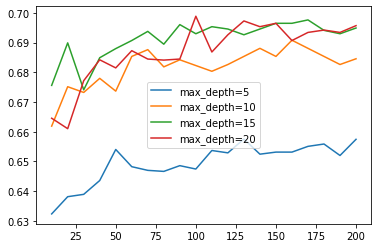

In [ ]:
for d in depth:
    subset = df_scores1[df_scores1.max_depth == d]
    
    plt.plot(subset.n_estimators, subset.auc,label='max_depth=%d' % d)

plt.legend()

In [ ]:
columns = ['max_depth', 'n_estimators', 'acc']
df_scores = pd.DataFrame(score, columns=columns)

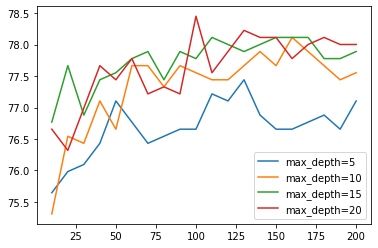

In [ ]:
for d in depth:
    subset = df_scores[df_scores.max_depth == d]
        
    plt.plot(subset.n_estimators, subset.acc,
             label='max_depth=%d' % d)

plt.legend()

If we consider auc score depth = 15 has a constant growth

In [ ]:
depth=15

In [ ]:
#getting samples
score1=[]

samples=[1,5,10,25,3,50]
for s in samples:
   for n in range(10,201,10):


    rmodel = RandomForestClassifier(n_estimators=n,random_state=1,max_depth=depth,min_samples_leaf=s)
    rmodel.fit(X_train, y_train)

    pred = rmodel.predict(X_val)
    acc= accuracy_score(y_val,pred)*100
    auc = roc_auc_score(y_val,pred)

    #print('%4s %s  %.2f %.3f'%(n,d,acc,auc))
    #score.append((d,n,acc))
    score1.append((s,n,auc))


In [ ]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(score1, columns=columns)

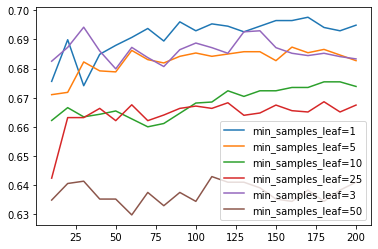

In [ ]:
for s in samples:
    subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(subset.n_estimators, subset.auc,
             label='min_samples_leaf=%d' % s)

plt.legend()

In our case min_sample_leaf=1 gives better auc
Also, at estimators=200, auc curves becomes high slightly compared to other values.

Finalizing our model

In [ ]:
rmodel = RandomForestClassifier(n_estimators=200,random_state=1,max_depth=15,min_samples_leaf=1)
rmodel.fit(X_train, y_train)

pred2 = rmodel.predict(X_val)

print('ACCURACY: ',accuracy_score(y_val,pred2)*100)
print('AUC score: ',roc_auc_score(y_val,pred2))

ACCURACY:  77.89001122334456
AUC score:  0.6948890572308293


# XGBoost

In [ ]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier()

xgb_model.fit(X_train, y_train)
prediction_xgb = xgb_model.predict(X_val)
print('ACCURACY: ',accuracy_score(y_val, prediction_xgb)*100)
print('AUC score: ',roc_auc_score(y_val,prediction_xgb))

ACCURACY:  78.45117845117845
AUC score:  0.6999841161233566


# Parameter tuning

In [ ]:
estimators=[50,100,150,200,250,300]
depth=[2,3,4,5,6]

score=[]
score1=[]

for d in depth:
  for n in estimators:
    xgb_model = XGBClassifier(learning_rate=0.05,n_estimators=n,max_depth=d)

    xgb_model.fit(X_train, y_train)
    prediction_xgb = xgb_model.predict(X_val)
    acc= accuracy_score(y_val,prediction_xgb)*100
    auc = roc_auc_score(y_val,prediction_xgb)

    score1.append((n,d,auc))
    score.append((n,d,acc))

In [ ]:
columns = ['n_estimators', 'max_depth', 'auc']
df_scores = pd.DataFrame(score1, columns=columns)


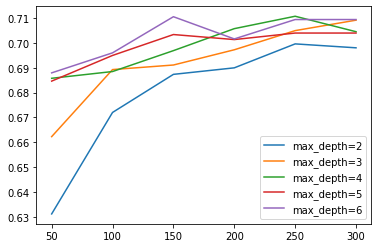

In [ ]:
for d in depth:
    subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(subset.n_estimators, subset.auc,
             label='max_depth=%d' % d)

plt.legend()

We'll finilaize by taking estimators=250, and depth=4

In [ ]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(learning_rate=0.05,n_estimators=250,max_depth=4)

xgb_model.fit(X_train, y_train)
prediction_xgb = xgb_model.predict(X_val)
print('ACCURACY: ',accuracy_score(y_val, prediction_xgb)*100)
print('AUC score: ',roc_auc_score(y_val,prediction_xgb))

ACCURACY:  79.01234567901234
AUC score:  0.710775988465862


# Selecting final model

1. **Decision tree**

ACCURACY:  76.21

AUC score: 0.676

2. **Random forest**

ACCURACY:  77.89001122334456

AUC score:  0.6948890572308293

3. **XGB **

ACCURACY:  79.01234567901234

AUC score:  0.710775988465862

Finalising XGB model

In [ ]:


#training with 80% of data --> X_full_train

from xgboost import XGBClassifier
xgb_model = XGBClassifier(learning_rate=0.05,n_estimators=250,max_depth=4)

xgb_model.fit(X_full_train, y_full_train)
prediction_xgb = xgb_model.predict(X_test)
print('ACCURACY: ',accuracy_score(y_test, prediction_xgb)*100)
print('AUC score: ',roc_auc_score(y_test,prediction_xgb))

ACCURACY:  85.97081930415264
AUC score:  0.7977162093434405
